#Store Sales - Time Series Forecasting

In [ ]:
pip install category_encoders


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.6 MB/s eta 0:00:00


#Loading Multiple datasets

In [ ]:
# Importing necessary libraries
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

from category_encoders import TargetEncoder
from sklearn.kernel_approximation import Nystroem
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline

# Setting up TensorFlow GPU memory growth
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# Configuring GPU memory growth
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
tf.config.list_physical_devices('GPU')

# Suppressing warnings and setting up random seeds for reproducibility
warnings.filterwarnings('ignore')
np.random.seed(1337)
tf.random.set_seed(1337)
train_data=pd.read_csv('/content/train.csv')
train_data

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


#Train Data

In [ ]:

# Loading datasets (assuming datasets are in the current working directory)
train = pd.read_csv("train.csv")
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


#Test Data

In [ ]:

test = pd.read_csv("test.csv")
test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


#Holidays Events Data

In [ ]:
holiday_events = pd.read_csv("holidays_events.csv")
holiday_events

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


#Oil Data

In [ ]:

oil = pd.read_csv("oil.csv")
oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


#Stores Data

In [ ]:
stores = pd.read_csv("stores.csv")
stores

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


#Data preprocessing

In [ ]:
# Converting date features to datetime data type
train["date"] = pd.to_datetime(train["date"])
test["date"] = pd.to_datetime(test["date"])
holiday_events["date"] = pd.to_datetime(holiday_events["date"])
oil["date"] = pd.to_datetime(oil["date"])

#Data Visualization

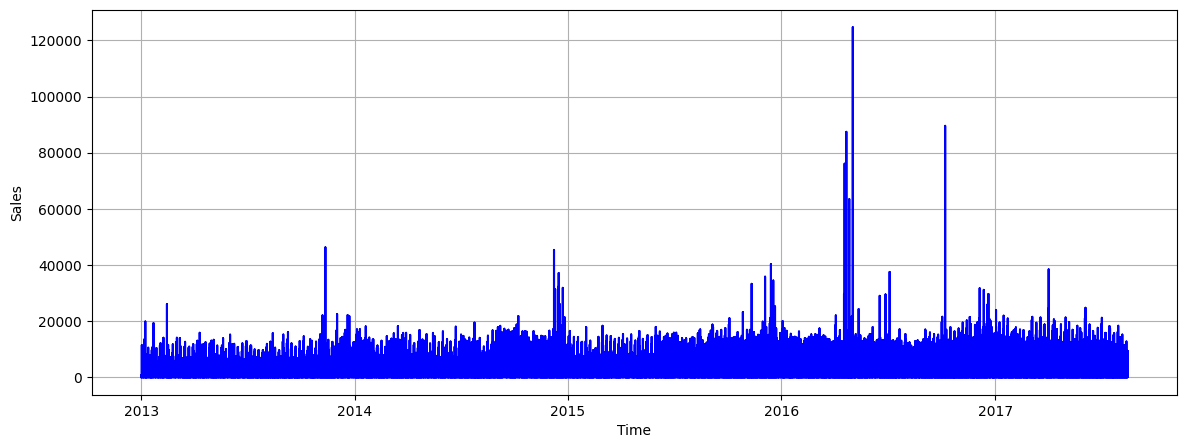

In [ ]:
# Exploratory Data Analysis (EDA)

# Plotting time series data
def plot_series(time, series, format="-", start=0, end=None):
    fig, ax = plt.subplots(figsize=(14, 5))
    plt.plot(time[start:end], series[start:end], format, color='blue')  # Updated color
    plt.xlabel("Time")
    plt.ylabel("Sales")
    plt.grid(True)
    plt.show()
    plt.close()

plot_series(train["date"], train["sales"], format="-", start=0, end=None)